RFM SEGMENTATION & CLV ANALYSIS

Dataset: 386,038 transactions
Unique Customers: 4,337
Date range: 2010-12-01 to 2011-12-09
Reference date (for Recency): 2011-12-10

CALCULATING RFM METRICS

Customers analyzed: 4,337

=== RFM RAW METRICS (Sample) ===
   CustomerID  Recency  Frequency  Monetary
0    12346.00      326          1  77183.60
1    12347.00        2          7   4265.00
2    12348.00       75          4   1437.24
3    12349.00       19          1   1439.70
4    12350.00      310          1    254.20
5    12352.00       36          8   2173.84
6    12353.00      204          1     89.00
7    12354.00      232          1    843.34
8    12355.00      214          1    459.40
9    12356.00       23          3   2410.03

=== RFM DESCRIPTIVE STATS ===
       Recency  Frequency  Monetary
count  4337.00    4337.00   4337.00
mean     92.61       4.25   1983.38
std      99.98       7.66   8759.40
min       1.00       1.00      3.75
25%      18.00       1.00    296.64
50%      51.00    

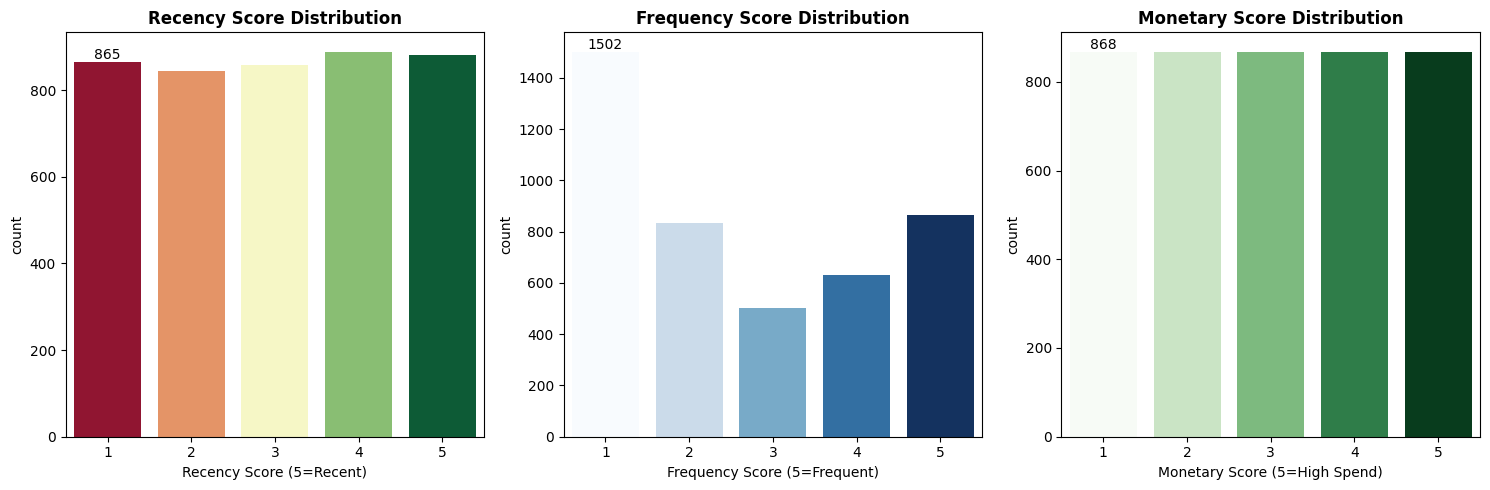

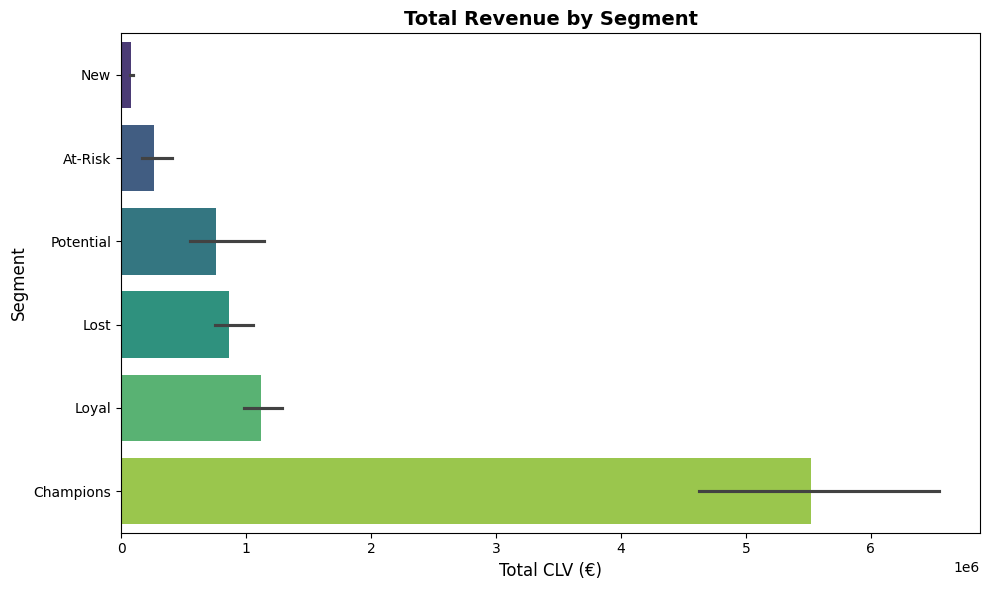


CONNECTION TO COHORT ANALYSIS

=== SEGMENT DISTRIBUTION BY COHORT ===

2010-12 Cohort:
Segment
Champions   46.80
Lost        23.90
Loyal       18.10
Potential    6.70
At-Risk      4.50
Name: proportion, dtype: float64

Rest Cohorts:
Segment
Lost        49.10
Champions   14.50
Potential   13.60
Loyal       11.30
New          7.10
At-Risk      4.40
Name: proportion, dtype: float64

✅ KEY FINDING:
   2010-12 cohort has 46.8% Champions
   Rest cohorts have 14.5% Champions
   Difference: +32.3pp

   → Confirms Notebook 01 finding: First cohort has superior customer quality

✅ RFM segments saved to rfm_segments.csv


In [ ]:
# ============================================================================
# 02. RFM SEGMENTATION & CLV ANALYSIS
# Business question: Who are my best customers and which are at risk?
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


# Format
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# ============================================================================
## 1. DATA LOADING
# ============================================================================

retail_clean = pd.read_csv('online_retail_clean.csv', parse_dates=['InvoiceDate'])

print('='*70)
print('RFM SEGMENTATION & CLV ANALYSIS')
print('='*70)

print(f'\nDataset: {len(retail_clean):,} transactions')
print(f'Unique Customers: {retail_clean["CustomerID"].nunique():,}')
print(f'Date range: {retail_clean["InvoiceDate"].min().date()} to {retail_clean["InvoiceDate"].max().date()}')

# Reference date for Recency calculation (last date + 1 day)
reference_date = retail_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f'Reference date (for Recency): {reference_date.date()}')

# ============================================================================
## 2. RFM CALCULATION (Customer-Level Metrics)
# ============================================================================

print('\n' + '='*70)
print('CALCULATING RFM METRICS')
print('='*70)

# Calculate RFM at customer level
rfm_data = retail_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'Revenue': 'sum'                                            # Monetary
}).reset_index()

rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Remove negative Monetary (returns only)
rfm_data = rfm_data[rfm_data['Monetary'] > 0]

print(f'\nCustomers analyzed: {len(rfm_data):,}')
print('\n=== RFM RAW METRICS (Sample) ===')
print(rfm_data.head(10))

print('\n=== RFM DESCRIPTIVE STATS ===')
print(rfm_data[['Recency', 'Frequency', 'Monetary']].describe())

# ============================================================================
## 3. RFM SCORING (Percentile-Based)
# ============================================================================

print('\n' + '='*70)
print('RFM SCORING (Percentile-Based)')
print('='*70)

# Recency Score (INVERTED: lower recency = better = higher score)
rfm_data['R_score'] = pd.cut(
    rfm_data['Recency'],
    bins=[0, 
          rfm_data['Recency'].quantile(0.2),
          rfm_data['Recency'].quantile(0.4),
          rfm_data['Recency'].quantile(0.6),
          rfm_data['Recency'].quantile(0.8),
          rfm_data['Recency'].max()],
    labels=[5, 4, 3, 2, 1],
    include_lowest=True
)

# Frequency Score (higher frequency = better = higher score)
rfm_data['F_score'] = pd.cut(
    rfm_data['Frequency'],
    bins=[0,
          rfm_data['Frequency'].quantile(0.2),
          rfm_data['Frequency'].quantile(0.4),
          rfm_data['Frequency'].quantile(0.6),
          rfm_data['Frequency'].quantile(0.8),
          rfm_data['Frequency'].max()],
    labels=[1, 2, 3, 4, 5],
    include_lowest=True,
    duplicates='drop'
)

# Monetary Score (higher monetary = better = higher score)
rfm_data['M_score'] = pd.cut(
    rfm_data['Monetary'],
    bins=[0,
          rfm_data['Monetary'].quantile(0.2),
          rfm_data['Monetary'].quantile(0.4),
          rfm_data['Monetary'].quantile(0.6),
          rfm_data['Monetary'].quantile(0.8),
          rfm_data['Monetary'].max()],
    labels=[1, 2, 3, 4, 5],
    include_lowest=True,
    duplicates='drop'
)

# Fill NaN (if any due to duplicates) with median score
rfm_data['R_score'] = rfm_data['R_score'].fillna(3)
rfm_data['F_score'] = rfm_data['F_score'].fillna(3)
rfm_data['M_score'] = rfm_data['M_score'].fillna(3)

# Convert to int
rfm_data['R_score'] = rfm_data['R_score'].astype(int)
rfm_data['F_score'] = rfm_data['F_score'].astype(int)
rfm_data['M_score'] = rfm_data['M_score'].astype(int)

print('\n=== RFM SCORE DISTRIBUTION ===')
print(f"\nRecency Score (5=recent, 1=old):")
print(rfm_data['R_score'].value_counts().sort_index())

print(f"\nFrequency Score (5=frequent, 1=rare):")
print(rfm_data['F_score'].value_counts().sort_index())

print(f"\nMonetary Score (5=high spend, 1=low):")
print(rfm_data['M_score'].value_counts().sort_index())

# Validate scoring makes sense
print('\n=== SCORING VALIDATION ===')
print('\nAverage Raw Metrics by Score:')
for score in [1, 2, 3, 4, 5]:
    r_avg = rfm_data[rfm_data['R_score']==score]['Recency'].mean()
    f_avg = rfm_data[rfm_data['F_score']==score]['Frequency'].mean()
    m_avg = rfm_data[rfm_data['M_score']==score]['Monetary'].mean()
    print(f'\nScore {score}:')
    print(f'  Avg Recency: {r_avg:.0f} days')
    print(f'  Avg Frequency: {f_avg:.1f} orders')
    print(f'  Avg Monetary: €{m_avg:,.0f}')

# ============================================================================
## 4. RFM SEGMENTATION (Business Labels)
# ============================================================================

print('\n' + '='*70)
print('RFM SEGMENTATION')
print('='*70)

def rfm_segment(row):
    """
    RFM Segmentation based on industry best practices.
    
    Segments:
    - Champions: Best customers (R≥4, F≥4, M≥4)
    - Loyal: Frequent buyers with good spend (F≥4, M≥3)
    - Potential: Good prospects (R≥3, F≥2, M≥3)
    - At-Risk: Good history but recently inactive (R≤2, F≥3)
    - New: Recent first purchase (R≥4, F=1)
    - Lost: Inactive across all metrics (catch-all)
    """
    R = row['R_score']
    F = row['F_score']
    M = row['M_score']
    
    if R >= 4 and F >= 4 and M >= 4:
        return 'Champions'
    elif F >= 4 and M >= 3:
        return 'Loyal'
    elif R >= 3 and F >= 2 and M >= 3:
        return 'Potential'
    elif R <= 2 and F >= 3:
        return 'At-Risk'
    elif R >= 4 and F == 1:
        return 'New'
    else:
        return 'Lost'

# Apply segmentation
rfm_data['Segment'] = rfm_data.apply(rfm_segment, axis=1)

# Segment distribution
print('\n=== SEGMENT DISTRIBUTION ===')
segment_dist = rfm_data['Segment'].value_counts()
segment_pct = (segment_dist / len(rfm_data) * 100).round(1)
segment_summary = pd.DataFrame({
    'Count': segment_dist,
    'Percentage': segment_pct.apply(lambda x: f'{x}%')
})
print(segment_summary)

# Segment validation (check if logic makes sense)
print('\n=== SEGMENT PROFILE (Average Metrics) ===')
segment_profile = rfm_data.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(1)
print(segment_profile.sort_values('Monetary', ascending=False))

# ============================================================================
## 5. CLV ANALYSIS BY SEGMENT
# ============================================================================

print('\n' + '='*70)
print('CLV ANALYSIS BY SEGMENT')
print('='*70)

# Calculate CLV metrics
rfm_data['CLV'] = rfm_data['Monetary']  # Simple CLV = total historical spend
rfm_data['AOV'] = rfm_data['Monetary'] / rfm_data['Frequency']

# CLV by segment
clv_by_segment = rfm_data.groupby('Segment').agg({
    'CLV': ['mean', 'median', 'sum'],
    'AOV': 'mean',
    'Frequency': 'mean',
    'CustomerID': 'count'
}).round(2)

clv_by_segment.columns = ['Avg_CLV', 'Median_CLV', 'Total_CLV', 'Avg_AOV', 'Avg_Frequency', 'Count']
clv_by_segment = clv_by_segment.sort_values('Total_CLV', ascending=False)

print(clv_by_segment)

# Revenue concentration
total_revenue = rfm_data['CLV'].sum()
clv_by_segment['Revenue_Share'] = (clv_by_segment['Total_CLV'] / total_revenue * 100).round(1)

print('\n=== REVENUE CONCENTRATION ===')
print(clv_by_segment[['Count', 'Total_CLV', 'Revenue_Share']])

# Pareto principle check
champions_revenue_share = clv_by_segment.loc['Champions', 'Revenue_Share']
champions_customer_share = (clv_by_segment.loc['Champions', 'Count'] / len(rfm_data) * 100).round(1)

print(f'\n📊 PARETO ANALYSIS:')
print(f'   Champions represent {champions_customer_share}% of customers')
print(f'   but generate {champions_revenue_share}% of revenue')

# ============================================================================
## 6. VISUALIZATION: RFM SCORES & SEGMENTS
# ============================================================================

# 6A: RFM Score Distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recency
sns.countplot(data=rfm_data, x='R_score', hue='R_score',
              ax=axes[0], palette='RdYlGn', legend=False)
axes[0].set_title('Recency Score Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Recency Score (5=Recent)')
axes[0].bar_label(axes[0].containers[0])

# Frequency
sns.countplot(data=rfm_data, x='F_score', hue='F_score',
              ax=axes[1], palette='Blues', legend=False)
axes[1].set_title('Frequency Score Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Frequency Score (5=Frequent)')
axes[1].bar_label(axes[1].containers[0])

# Monetary
sns.countplot(data=rfm_data, x='M_score', hue='M_score',
              ax=axes[2], palette='Greens', legend=False)
axes[2].set_title('Monetary Score Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Monetary Score (5=High Spend)')
axes[2].bar_label(axes[2].containers[0])

plt.tight_layout()
plt.show()


# 6B: Segment Distribution
fig, ax = plt.subplots(figsize=(10, 6))
segment_order = clv_by_segment.sort_values('Total_CLV', ascending=True).index
sns.barplot(
    data=rfm_data, 
    y='Segment', 
    x='CLV',
    order=segment_order,
    estimator=sum,
    palette='viridis',
    ax=ax
)
ax.set_title('Total Revenue by Segment', fontsize=14, fontweight='bold')
ax.set_xlabel('Total CLV (€)', fontsize=12)
ax.set_ylabel('Segment', fontsize=12)
plt.tight_layout()
plt.show()

# ============================================================================
## 7. CONNECTION TO NOTEBOOK 01 (Cohort Analysis)
# ============================================================================

print('\n' + '='*70)
print('CONNECTION TO COHORT ANALYSIS')
print('='*70)

# Load first_purchase data from Notebook 01
first_purchase = (
    retail_clean.groupby('CustomerID')['InvoiceDate']
    .min()
    .reset_index()
    .rename(columns={'InvoiceDate': 'first_purchase_date'})
)
first_purchase['cohort'] = first_purchase['first_purchase_date'].dt.to_period('M').astype(str)

# Merge with RFM data
rfm_cohort = rfm_data.merge(first_purchase[['CustomerID', 'cohort']], on='CustomerID', how='left')

# Compare 2010-12 vs rest
cohort_2010_12 = rfm_cohort[rfm_cohort['cohort'] == '2010-12']
rest_cohorts = rfm_cohort[rfm_cohort['cohort'] > '2010-12']

print('\n=== SEGMENT DISTRIBUTION BY COHORT ===')
print('\n2010-12 Cohort:')
print(cohort_2010_12['Segment'].value_counts(normalize=True).mul(100).round(1))

print('\nRest Cohorts:')
print(rest_cohorts['Segment'].value_counts(normalize=True).mul(100).round(1))

# Champions rate comparison
champions_2010_12 = (cohort_2010_12['Segment'] == 'Champions').mean() * 100
champions_rest = (rest_cohorts['Segment'] == 'Champions').mean() * 100

print(f'\n✅ KEY FINDING:')
print(f'   2010-12 cohort has {champions_2010_12:.1f}% Champions')
print(f'   Rest cohorts have {champions_rest:.1f}% Champions')
print(f'   Difference: {champions_2010_12 - champions_rest:+.1f}pp')
print(f'\n   → Confirms Notebook 01 finding: First cohort has superior customer quality')

# ============================================================================
## 8. SAVE RFM SEGMENTS
# ============================================================================
rfm_data.to_csv('rfm_segments.csv', index=False)
print('\n✅ RFM segments saved to rfm_segments.csv')



